# Trazadores cíbicos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/caramirezs/MetNum_202210/blob/main/2_Ajuste_de_curvas/2.3_Trazadores_cubicos.ipynb)

In [3]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from tabulate import tabulate

In [4]:
# GRAFICA
# Puntos para graficar cada tramo
def graficar(px_tabla, muestras = 10):
    xtraza = np.array([])
    ytraza = np.array([])
    tramo = 1
    while not(tramo>=n):
        a = xi[tramo-1]
        b = xi[tramo]
        xtramo = np.linspace(a,b,muestras)

        # evalua polinomio del tramo
        pxtramo = px_tabla[tramo-1]
        pxt = sym.lambdify('x',pxtramo)
        ytramo = pxt(xtramo)

        # vectores de trazador en x,y
        xtraza = np.concatenate((xtraza,xtramo))
        ytraza = np.concatenate((ytraza,ytramo))
        tramo = tramo + 1

    # Gráfica
    plt.plot(xi,fi,'ro', label='puntos')
    plt.plot(xtraza,ytraza, label='trazador'
             , color='blue')
    plt.title('Trazadores Cúbicos Naturales')
    plt.xlabel('xi')
    plt.ylabel('px(xi)')
    plt.legend()
    plt.show()

In [5]:
def trazador_cubico(xi,yi):
    n = len(xi) # Cantidad de parejas x, y (n)
    print(f'n: {n}')

    # Valores h
    h = np.zeros(n-1, dtype = float) # Genera una arreglo h lleno de 0's flotante con n-1 índices
    for j in range(0,n-1,1): # Itera desde 0 hasta n-1 de uno en uno
        h[j] = xi[j+1] - xi[j] # llena el arreglo h con las diferencias de x_i con x_i+1 (x[i] - x[i+1])

    # Valores m
    m = np.zeros(n-1, dtype = float) # Genera una arreglo h lleno de 0's flotante con n-1 índices
    for j in range(0,n-1,1): # Itera desde 0 hasta n-1 de uno en uno
        m[j] = (yi[j+1] - yi[j])/(xi[j+1] - xi[j]) # llena el arreglo m con (y_i - y_i-1)/(x_i - x_i-1)

    print(f'h: {h}')
    print(f'm: {m}')
    print("------------------------------------------------------")
        #Tabla índice, x, y, h y m
    tabla = np.zeros((n,5)) # Matriz con valores de puntos, h y m para una mejor visualización
    for i in range(0,n,1):
        tabla[i,0] = i
        tabla[i,1] = xi[i]
        tabla[i,2] = yi[i]
        if(i > 0):
            tabla[i,3] = h[i-1]
            tabla[i,4] = m[i-1]

    print(tabulate(tabla, headers=["i","x", "y", "h", "m"]))
    print("------------------------------------------------------")


    # Valores para hallar icógnitas C's
    EC_INI = np.zeros(shape=(n-2,n), dtype = float)   # Matriz para el sistema de ec
    EC_IG  = np.zeros(n-2, dtype = float)             # Arreglo del lado de la igualdad para el sistema ec
    EC_3   = np.zeros(shape=(n-2,n-2), dtype = float) # Arreglo inicial recortada de forma cuadrada

    #print(tabulate(EC_INI))
    #print(EC_IG)
    #print(tabulate(EC_3))


    indice_1 = 1

    for i in range(n-2):    # roptura de función para posteriormente encontrar escalares
        # h_i * C_i + 2(h_i + h_i+1) + h_i+1 * C_i+2 = 3(m_i+1 - m_i)

        parte_a = h[i]            # Parte 1 de la función h_i*C_i
        parte_b = 2*(h[i]+h[i+1]) # Parte 2 de la función 2(h_i + h_i+1)
        parte_c = h[i+1]          # Parte 3 de la función h_i+1*C_i+2

        EC_INI[i,indice_1-1] = parte_a
        EC_INI[i,indice_1] = parte_b
        EC_INI[i,indice_1+1] = parte_c

        indice_1 = indice_1 + 1

    for i in range(len(EC_IG)):  # roptura de función del lado derecho de la igualdad
        EC_IG[i] = 3*(m[i+1]-m[i]) # Parte 4 de la función 3(m_i+1 - m_i)


    for i in range(len(EC_3)): # Recorte de matriz para dejarla cuadrada, excluyendo C_1 y C_n+1 (natural/libre)
        for j in range(len(EC_3)):
            EC_3[i,j] = EC_INI[i,j+1]


    # Impresión de sistema de ecuaciones
    print(f'h_i * C_i + 2(h_i + h_i+1) + h_i+1 * C_i+2 = 3(m_i+1 - m_i)')
    print("------------------------------------------------------")
    print(f'{tabulate(EC_INI, headers=["C_1","C_2","C_3","C_4","C_5","C_7","C_8","C_9","C_10","C_11"])}\n') #Ecuación con todas las C's
    print("------------------------------------------------------")
    print(f'3(m_i+1 - m_i):\n{EC_IG}')
    print("------------------------------------------------------")
    print(f'h_i * C_i + 2(h_i + h_i+1) + h_i+1 * C_i+2\n{tabulate(EC_3, headers=["C_2","C_3","C_4","C_5","C_7","C_8","C_9","C_10","C_11"])}\n')

    r = np.linalg.solve(EC_3, EC_IG) # Encontrar icógnitas (C_2, C_3, ... C_n)

    c  = np.zeros(n, dtype = float)             # Ajuste Arreglo c para encontrar iteración ordenada
    #print(np.allclose(np.dot(EC_3, r), EC_IG))  # Comprueba que la solución es correcta

    index = 0
    for i in range(1, n-1, 1):
        c[i] = r[index]
        index += 1


    print(f"coeficientes:\nc:\n{c}\n")

    #2.Siguiente paso: Cálculo de coeficientes a, b y d

    a  = np.zeros(n-1, dtype = float)             # Arreglo para encontrar coeficiente a
    b  = np.zeros(n-1, dtype = float)             # Arreglo para encontrar coeficiente b
    d  = np.zeros(n-1, dtype = float)             # Arreglo para encontrar coeficiente d

    index = 1
    for i in range(0, n-1, 1): # Se realizan las operaciones para hallar a, b y d teniendo en cuenta la fórmula expuesta
        a[i] = yi[index-1]
        b[i] = m[i] - ((1/3)  * h[i] * (2*c[i] + c[i+1]))
        d[i] = (c[i+1] - c[i])/(3*h[i])

        index += 1

    print(f'a: y_i-1:\n{a}\n')
    print(f'b: m_i - (1/3)h_i(2C_i + C_i+1):\n{b}\n')
    print(f'd: (C_i+1 - C_i)/(3h_i):\n{d}\n')


    # Aplicación de la fórmula principal (requiere de haber encontrado a, b, c y d)
    # P_i(x) = a_i + b_i(x - x_i-1) + c_i(x - x_i)^2 + d_i(x - x_i+1)^3

    # Polinomio trazador

    x = sym.Symbol('x')
    polinomios = []

    index = 0
    for i in range(1,n,1):        # Se generan los polinomios correspondientes con base a la fórmula principal
        op = a[index]
        op = op + (b[index]*(x - xi[i-1]))
        op = op + (c[index]*(x - xi[i-1])**2)
        op = op + (d[index]*(x - xi[i-1])**3)
        op = op.expand()
        polinomios.append(op)
        index += 1

    print('Polinomios por tramos: ')
    for tramo in range(1,n,1):
        print(f'Polinomio {tramo}')
        print(' x = ['+str(xi[tramo-1]) +','+str(xi[tramo])+']')
        print(str(polinomios[tramo-1]) + '\n')

    print('\nPara graficar en geogebra:')
    for tramo in range(1,n,1):
        print(f'Polinomio {tramo}')
        print(str(polinomios[tramo-1]) + ' , ' + str(xi[tramo-1]) +'< x <'+str(xi[tramo])+'\n')
    return(polinomios)

n: 7
h: [2. 2. 2. 2. 3. 5.]
m: [ 1.          0.5        -1.         -0.5         0.66666667 -0.4       ]
------------------------------------------------------
  i    x    y    h          m
---  ---  ---  ---  ---------
  0    2    2    0   0
  1    4    4    2   1
  2    6    5    2   0.5
  3    8    3    2  -1
  4   10    2    2  -0.5
  5   13    4    3   0.666667
  6   18    2    5  -0.4
------------------------------------------------------
h_i * C_i + 2(h_i + h_i+1) + h_i+1 * C_i+2 = 3(m_i+1 - m_i)
------------------------------------------------------
  C_1    C_2    C_3    C_4    C_5    C_7    C_8
-----  -----  -----  -----  -----  -----  -----
    2      8      2      0      0      0      0
    0      2      8      2      0      0      0
    0      0      2      8      2      0      0
    0      0      0      2     10      3      0
    0      0      0      0      3     16      5

------------------------------------------------------
3(m_i+1 - m_i):
[-1.5 -4.5  1.5  3.5 -3.2]
-

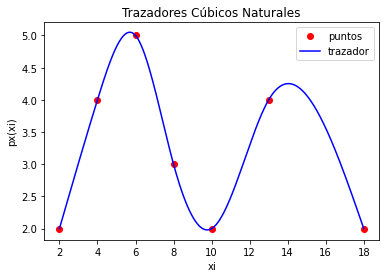

In [8]:
# Datos
xi = np.array([2, 4, 6, 8, 10, 13, 18])
fi = np.array([2, 4, 5, 3, 2, 4, 2])
muestras = 100 # entre cada par de puntos

# Llamado Metodo
n = len(xi)
px_tabla = trazador_cubico(xi,fi)

# Llamado Grafica
graficar(px_tabla, muestras)

In [14]:
px_tabla

[-0.00560222333667669*x**3 + 0.0336133400200602*x**2 + 0.955182213306586*x - 7.63278329429795e-17,
 -0.0969888833166165*x**3 + 1.13025325977934*x**2 - 3.43137746573053*x + 5.84874623871615,
 0.143557756603143*x**3 - 3.19958625877633*x**2 + 22.5476596456035*x - 46.1093279839519,
 0.0227578569040455*x**3 - 0.300388665997994*x**2 - 0.645921096623205*x + 15.740220661986,
 -0.0726707901482224*x**3 + 2.56247074557004*x**2 - 29.2745152123036*x + 111.168867714254,
 0.0181126713473755*x**3 - 0.978084252758275*x**2 + 16.7526997659646*x - 88.2823971915747]

In [12]:
# ---------------------------------------------------------------------
# Compendio de programas.
# Matemáticas para Ingeniería. Métodos numéricos con Python.
# Copyright (C) 2020 Los autores del texto.
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>
# ---------------------------------------------------------------------

# Trazadores cúbicos naturales y algunos casos de salida.

from math import *


def CubicSplines(datos):
    """
    Implementación trazadores cúbicos
    Entradas:
    datos -- lista de puntos (x, y) en el plano ordenados por x

    Salidas:
    a -- vector de coeficientes (constantes)
    b -- vector de coeficientes (lineales)
    c -- vector de coeficientes (cuadráticos)
    d -- vector de coeficientes (cúbicos)
    """
    n = len(datos)-1
    # Inicializar vectores auxiliares
    A = [x[1] for x in datos]
    X = [x[0] for x in datos]
    H = [0.0 for x in range(n)]
    B = [0.0 for x in range(n+1)]
    C = [0.0 for x in range(n+1)]
    D = [0.0 for x in range(n+1)]
    alpha = [0.0 for x in range(n)]
    mu = [0.0 for x in range(n+1)]
    lo = [1.0 for x in range(n+1)]
    z = [0.0 for x in range(n+1)]

    # Crear vector $H$
    for i in range(n):
        H[i] = X[i+1]-X[i]

    # Crear vector $\alpha$
    for i in range(1, n):
        alpha[i] = (3/H[i])*(A[i+1]-A[i])-(3/H[i-1])*(A[i]-A[i-1])

    # Solucionar sistema tridiagonal
    for i in range(1, n):
        lo[i] = 2*(X[i+1]-X[i-1])-H[i-1]*mu[i-1]
        mu[i] = H[i]/lo[i]
        z[i] = (alpha[i]-H[i-1]*z[i-1])/lo[i]

    # Solucionar sistema tridiagonal
    for j in range(n-1, -1, -1):
        C[j] = z[j]-mu[j]*C[j+1]
        B[j] = (A[j+1]-A[j])/(H[j])-H[j]*(C[j+1]+2*C[j])/3
        D[j] = (C[j+1]-C[j])/(3*H[j])

    # Retornar vectores $A$, $B$, $C$, $D$
    return A[:-1], B[:-1], C[:-1], D[:-1]

In [13]:

#Datos de prueba $(1,2)$, $(2,3)$, $(3,5)$
datosPrueba = [(2,2), (4,4), (6,5), (8,3), (10,2), (13,4), (18,2)]
a, b, c, d = CubicSplines(datosPrueba)
print("Vectores de coeficientes:")
print("A =", a)
print("B =", b)
print("C =", c)
print("D =", d)

Vectores de coeficientes:
A = [2, 4, 5, 3, 2, 4]
B = [1.0224088933467068, 0.9551822133065864, -0.3431377465730524, -1.0826312270143763, 0.17366265463055824, 0.5056335673687732]
C = [0.0, -0.03361334002006017, -0.6155466399197593, 0.24579989969909727, 0.3823470411233702, -0.27169007021063196]
D = [-0.005602223336676694, -0.09698888331661652, 0.14355775660314277, 0.022757856904045488, -0.07267079014822247, 0.018112671347375466]


In [35]:
from scipy.interpolate import CubicSpline
xi = np.array([2, 4, 6, 8, 10, 13, 18])
yi = np.array([2, 4, 5, 3, 2, 4, 2])
cs = CubicSpline(xi, yi, bc_type='natural')

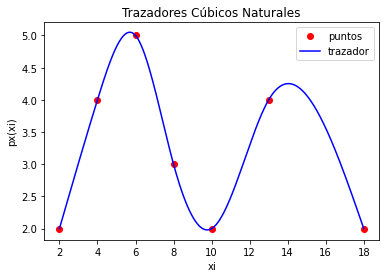

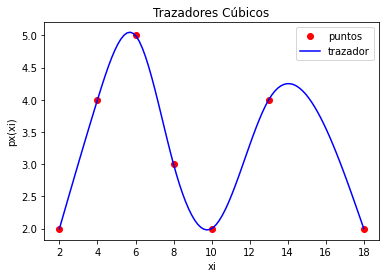

In [36]:
graficar(px_tabla, muestras)

plt.plot(xi,yi,'ro', label='puntos')
x = np.linspace(xi[0], xi[-1], 100)

plt.plot(x,cs(x), label='trazador', color='blue')
plt.title('Trazadores Cúbicos')
plt.xlabel('xi')
plt.ylabel('px(xi)')
plt.legend()
plt.show()

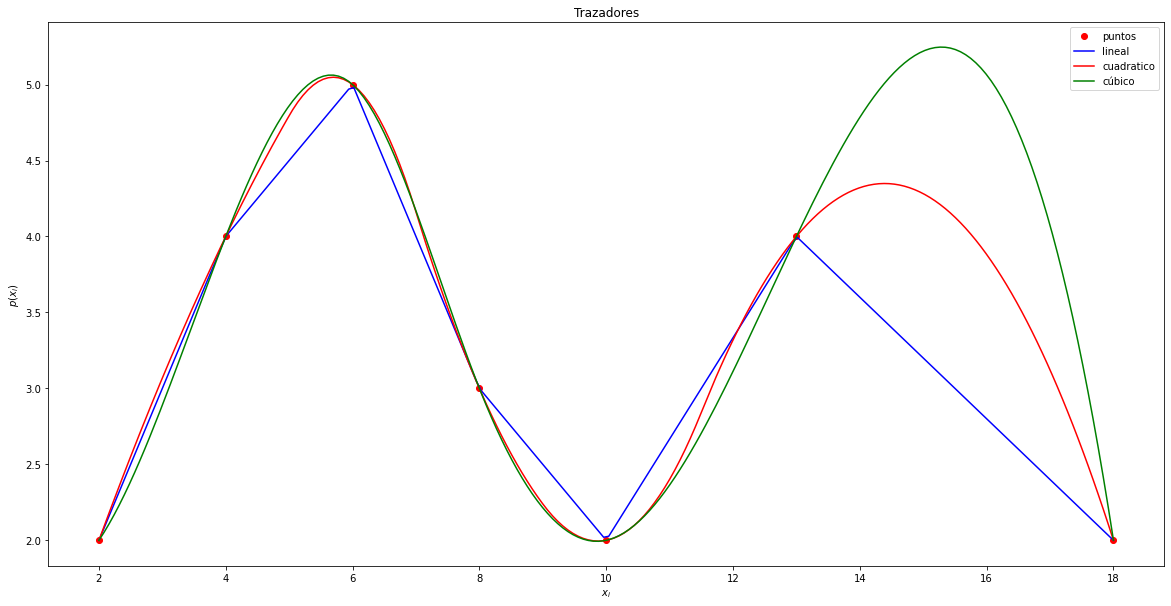

In [57]:
from scipy.interpolate import interp1d
xi = np.array([2, 4, 6, 8, 10, 13, 18])
yi = np.array([2, 4, 5, 3, 2, 4, 2])
c_lineal = interp1d(xi, yi)
c_cuad = interp1d(xi, yi, kind=2)
c_cubic = interp1d(xi, yi, kind=3)

plt.figure(figsize=(20,10))

plt.plot(xi,yi,'ro', label='puntos')
x = np.linspace(xi[0], xi[-1], 200)

plt.plot(x,c_lineal(x), label='lineal', color='blue')
plt.plot(x,c_cuad(x), label='cuadratico', color='red')
plt.plot(x,c_cubic(x), label='cúbico', color='green')
plt.title('Trazadores')
plt.xlabel('$x_i$')
plt.ylabel('$p(x_i)$')
plt.legend()
plt.show()